In [1]:
import os
import numpy as np
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras import optimizers
from keras.preprocessing import image
from PIL import Image,ImageOps
import cv2
import matplotlib.pyplot as plt

In [2]:
img_rows, img_cols = 32 , 32

In [3]:
isolated_train_path = r'H:\CVPR\bng_isolated_compound\Train'
isolated_test_path = r'H:\CVPR\bng_isolated_compound\Test'

In [4]:
for root, dirnames, filenames in os.walk(isolated_train_path):
    for filename in filenames:
        file_path = os.path.join(root, filename)
        img = Image.open(file_path)
        Grey = img.resize((img_rows, img_cols))
        #img = ImageOps.invert(img)
        #Grey = img.convert('L')
        #ret,thresh1 = cv.threshold(Grey,127,255,cv.THRESH_BINARY)
        #threshold = 105
        #Grey = Grey.point(lambda p: p < threshold and 255)
        #Grey = ImageOps.invert(img)
        Grey = Grey.convert('RGB')
        Grey.save(file_path)

In [5]:
train_data_dir = isolated_train_path
validation_data_dir = isolated_test_path

In [6]:
img_width, img_height, channel = img_rows, img_cols, 3
batch_size = 32

In [7]:
datagen = ImageDataGenerator(rescale=1./255)

#automatically retrive images and their classes for training and validation
train_generator = datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width,img_height),
        batch_size=batch_size,
        shuffle= True,
        class_mode ='categorical')

validation_generator = datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_width,img_height),
        batch_size=batch_size,
        shuffle= False,
        class_mode ='categorical')

Found 13258 images belonging to 24 classes.
Found 3316 images belonging to 24 classes.


In [8]:
IMG_SHAPE = img_cols, img_rows, 3
classes = 24

In [9]:
num_epoch = 50
num_train_samples = train_generator.samples
num_validation_samples = validation_generator.samples

print('num_train_samples: ' + str(num_train_samples))
print('num_validation_samples: ' + str(num_validation_samples))

num_train_samples: 13258
num_validation_samples: 3316


In [10]:
import tensorflow
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, BatchNormalization, ReLU, ELU, Dropout, Conv2D, Dense, MaxPool2D, AvgPool2D, GlobalAvgPool2D, Concatenate

In [11]:
def batch_normalization_relu_conv(x, filters, kernel_size):
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
   
    #x =  tensorflow.keras.layers.Dropout(0.1)(x)
    
    return x

In [12]:
def dense_block(tensor, k, reps):
    for _ in range(reps):
        x = batch_normalization_relu_conv(tensor, filters=4*k, kernel_size=1)
        x = batch_normalization_relu_conv(x, filters=k, kernel_size=3)
        #x =  tensorflow.keras.layers.Dropout(0.1)(x)
        tensor = Concatenate()([tensor, x])
    return tensor

In [13]:
def transition_layer(x, theta):
    f = int(tensorflow.keras.backend.int_shape(x)[-1] * theta)
    x = batch_normalization_relu_conv(x, filters=f, kernel_size=1)
    #x =  tensorflow.keras.layers.Dropout(0.1)(x)
    #x = BatchNormalization()(x)
    x = AvgPool2D(pool_size=2, strides=2, padding='same')(x)
    return x

In [14]:
k = 12
theta = 0.5
repetitions = 10, 14, 16
input_layer = Input(IMG_SHAPE)

In [15]:
x = Conv2D(2*k, 7, strides=2, padding='same')(input_layer)
x = Dropout(0.1)(x)
x = MaxPool2D(3, strides=2, padding='same')(x)
#x = BatchNormalization()(x)

In [16]:
d = None
for reps in repetitions:
    d = dense_block(x, k, reps)
    x = transition_layer(d, theta)
    #x = BatchNormalization()(x)
    
#x = BatchNormalization()(x)
x = GlobalAvgPool2D()(d)

output_layer = Dense(classes, activation='softmax')(x)

model = Model(input_layer, output_layer)

In [17]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 16, 16, 24)   3552        ['input_1[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 16, 16, 24)   0           ['conv2d[0][0]']                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 8, 8, 24)     0           ['dropout[0][0]']                
                                                                                              

In [18]:
opt = tensorflow.keras.optimizers.Adam()

In [19]:
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [20]:
history_1= model.fit_generator(train_generator,
                    steps_per_epoch=num_train_samples // batch_size,
                    epochs=50,
                    validation_data=validation_generator,
                    validation_steps=num_validation_samples // batch_size)

C:\Users\va5to\AppData\Local\Temp\ipykernel_14436\193625105.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_1= model.fit_generator(train_generator,


Epoch 1/50
414/414 [==============================] - 181s 287ms/step - loss: 1.2657 - accuracy: 0.6229 - val_loss: 0.5920 - val_accuracy: 0.8180
Epoch 2/50
414/414 [==============================] - 64s 154ms/step - loss: 0.3405 - accuracy: 0.8897 - val_loss: 0.3112 - val_accuracy: 0.8984
Epoch 3/50
414/414 [==============================] - 65s 157ms/step - loss: 0.1981 - accuracy: 0.9369 - val_loss: 0.1739 - val_accuracy: 0.9378
Epoch 4/50
414/414 [==============================] - 65s 156ms/step - loss: 0.1473 - accuracy: 0.9540 - val_loss: 0.1424 - val_accuracy: 0.9542
Epoch 5/50
414/414 [==============================] - 63s 153ms/step - loss: 0.1129 - accuracy: 0.9644 - val_loss: 0.2306 - val_accuracy: 0.9235
Epoch 6/50
414/414 [==============================] - 64s 155ms/step - loss: 0.1034 - accuracy: 0.9673 - val_loss: 0.1617 - val_accuracy: 0.9502
Epoch 7/50
414/414 [==============================] - 56s 136ms/step - loss: 0.0868 - accuracy: 0.9717 - val_loss: 0.0961 - val_a

In [21]:
import seaborn as sns

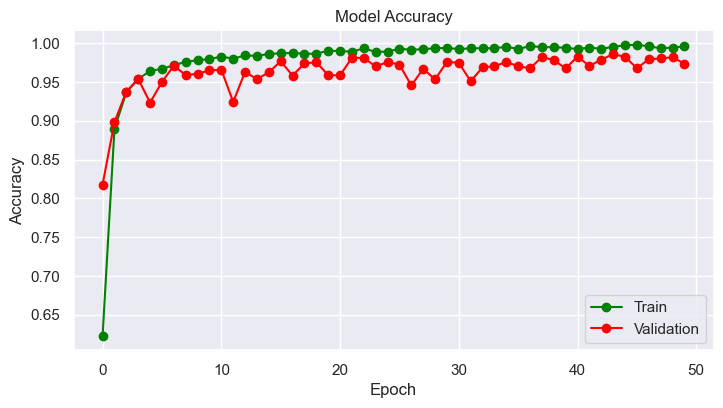

In [22]:
#  "Accuracy"
plt.figure(figsize=[8, 4])
sns.set_theme()
plt.plot(history_1.history['accuracy'], 'o-', color="Green")
plt.plot(history_1.history['val_accuracy'] , 'o-', color="Red")
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
#plt.show()
plt.gca().set_position([0.1, 0.12, 0.8, 0.8])
plt.savefig(r'H:\CVPR\Graph\CompoundDenseAccuracy1.svg')
plt.savefig(r'H:\CVPR\Graph\CompoundDenseAccuracy1.png')

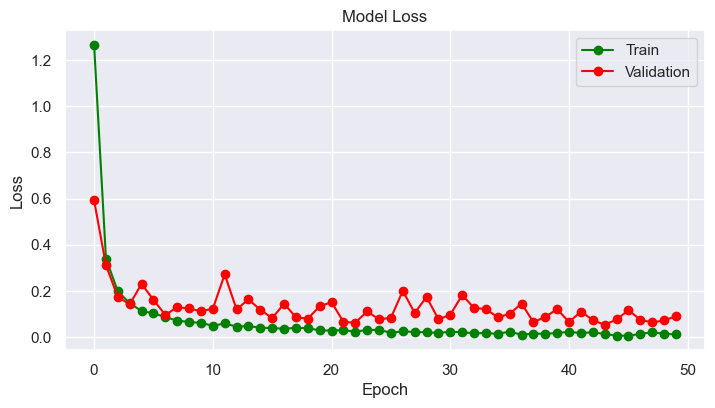

In [23]:
# "Loss"
plt.figure(figsize=[8, 4])
sns.set_theme()
plt.plot(history_1.history['loss'], 'o-', color="Green")
plt.plot(history_1.history['val_loss'], 'o-', color="Red")
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
#plt.show()
plt.gca().set_position([0.1, 0.12, 0.8, 0.8])
plt.savefig(r'H:\CVPR\Graph\CompoundDenseLoss1.svg')
plt.savefig(r'H:\CVPR\Graph\CompoundDenseLoss1.png')

In [24]:
%matplotlib inline
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

In [25]:
batch_size=20

In [26]:
Y_pred = model.predict_generator(validation_generator, num_validation_samples// batch_size+1)
print(Y_pred.shape)
y_pred = np.argmax(Y_pred, axis=1)
y_true= validation_generator.classes

target_names = ['61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81','82','83','84']
print(classification_report(y_true, y_pred, target_names=target_names, digits=3))

C:\Users\va5to\AppData\Local\Temp\ipykernel_14436\1064366204.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred = model.predict_generator(validation_generator, num_validation_samples// batch_size+1)


(3316, 24)
              precision    recall  f1-score   support

          61      0.979     0.946     0.962       148
          62      0.980     1.000     0.990       150
          63      1.000     0.993     0.996       135
          64      0.924     0.985     0.954       136
          65      0.984     0.938     0.960       129
          66      0.980     1.000     0.990       149
          67      0.993     0.993     0.993       135
          68      1.000     0.980     0.990       149
          69      0.992     0.944     0.967       126
          70      1.000     0.977     0.989       133
          71      0.789     0.985     0.876       133
          72      0.933     0.984     0.958       127
          73      0.993     1.000     0.996       133
          74      0.987     1.000     0.993       150
          75      0.986     0.993     0.989       141
          76      0.991     1.000     0.996       116
          77      1.000     0.993     0.996       140
          78    

In [27]:
cm = confusion_matrix(y_true, y_pred)

In [28]:
classes=24

In [29]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.BuGn
                         ):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(12,12))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1]), ):
        plt.text(j, i, cm[i, j, ],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()    
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
    

In [34]:
import imp
imp.reload(sns)

<module 'seaborn' from 'C:\\Users\\va5to\\anaconda3\\lib\\site-packages\\seaborn\\__init__.py'>

In [35]:
sns.reset_defaults()

In [36]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from matplotlib.font_manager import FontProperties

# plt.figure() 
# prop = FontProperties()
# prop.set_file('Siyamrupali.ttf')

In [37]:
cm_plot_labels = ['61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81','82','83','84']
#sns.set_theme()
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')
plt.savefig(r'H:\CVPR\Graph\CompoundDenseCNF1.svg')
plt.savefig(r'H:\CVPR\Graph\CompoundDenseCNF1.png')

Confusion matrix, without normalization
[[140   0   0   0   0   0   0   0   0   0   0   8   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0 150   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0   0 134   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   1   0   0   0]
 [  0   0   0 134   1   0   0   0   0   0   0   0   0   1   0   0   0   0
    0   0   0   0   0   0]
 [  0   0   0   8 121   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0   0   0   0   0 149   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0   0   0   0   0   1 134   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0   0   0   1   0   1   0 146   0   0   0   0   0   0   0   1   0   0
    0   0   0   0   0   0]
 [  2   0   0   0   0   1   0   0 119   0   4   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0   0   0   0   1   0   1   0   0 130   0   1  